In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:

df = pd.read_csv('./ETH-USD.csv', index_col=['Date'])

In [3]:
eth_price = pd.DataFrame(df['Close']).rename(columns={'Close':"Price"})

In [4]:
eth_price

,Price
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
...,...
2023-03-17,1792.485107
2023-03-18,1761.659668
2023-03-19,1785.576538


In [5]:
eth_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1959 entries, 2017-11-09 to 2023-03-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1959 non-null   float64
dtypes: float64(1)
memory usage: 30.6+ KB


<Axes: xlabel='Date'>

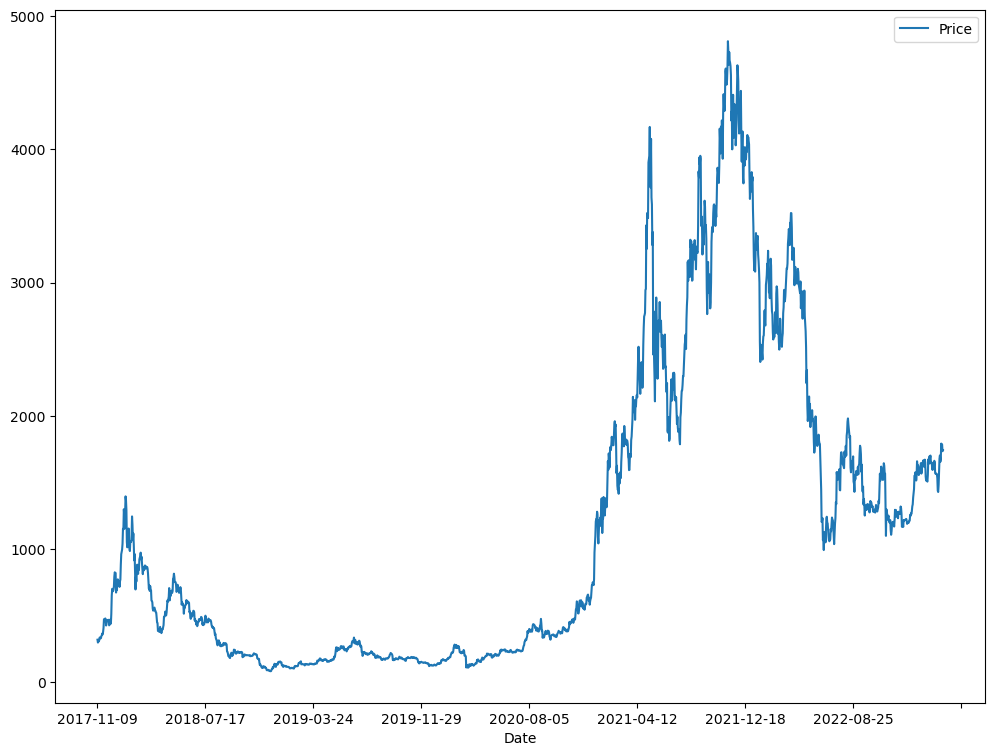

In [6]:
eth_price.plot(figsize=(12,9))

In [7]:
timesteps = eth_price.index.to_numpy()
prices = eth_price['Price'].to_numpy()

In [8]:
train_size = int(len(prices) * 0.8)

In [9]:
X_train, y_train = timesteps[:train_size], prices[:train_size]
X_test, y_test = timesteps[train_size:], prices[train_size:]

In [10]:
def plot_sets(X_train, y_train, X_test, y_test):
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.plot(X_train, y_train, label='train')
  ax.plot(X_test, y_test, label='test')
  ax.set(title='ETH Price', ylabel='Price', xlabel='Date')
  ax.legend()

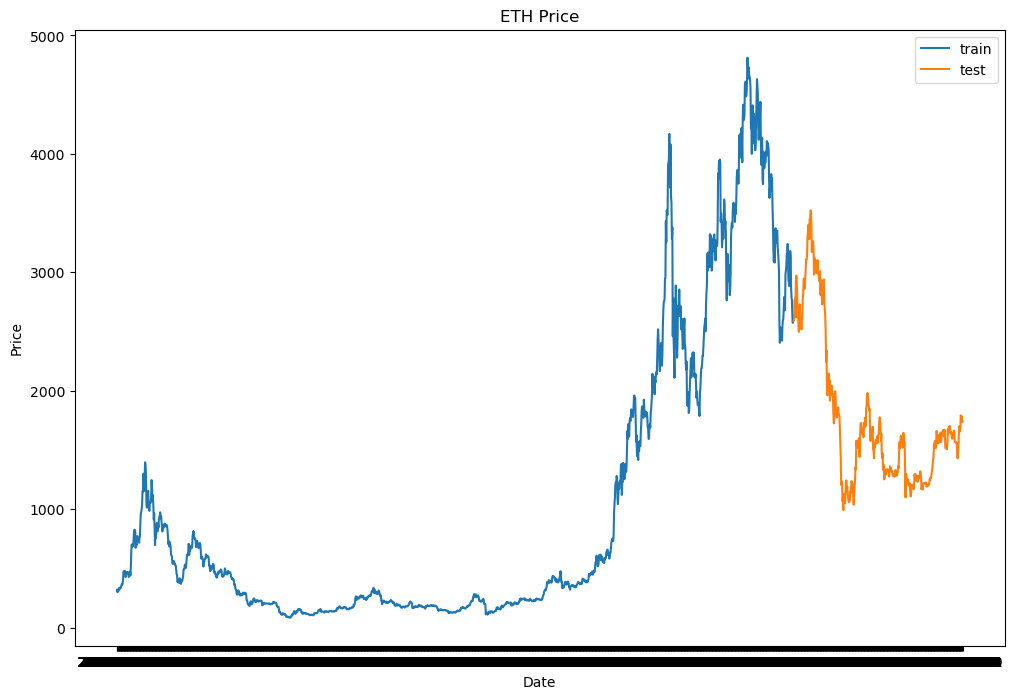

In [11]:
plot_sets(X_train, y_train, X_test, y_test)

In [12]:
naive = y_test[:-1]
naive[:10], naive[-10:]

(array([2590.359619, 2598.067139, 2764.535645, 2781.111816, 2621.801758,
        2919.201172, 2972.485107, 2950.118408, 2834.468994, 2617.156006]),
 array([1482.616699, 1590.292969, 1680.30896 , 1703.50708 , 1656.180542,
        1677.215454, 1792.485107, 1761.659668, 1785.576538, 1735.321289]))

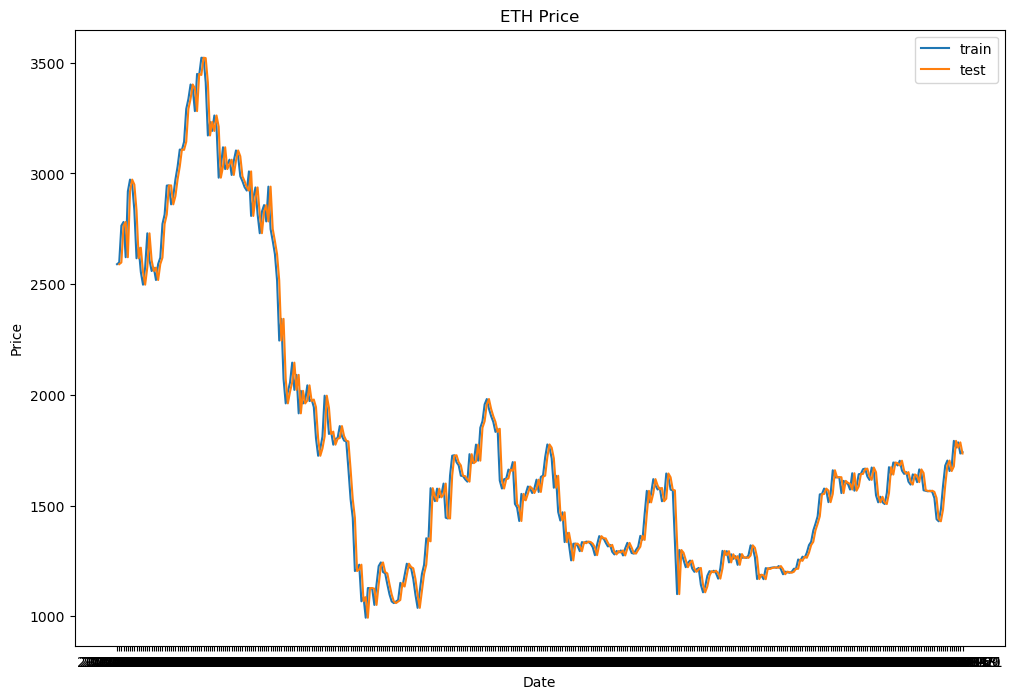

In [13]:
plot_sets(X_test, y_test, X_test[1:], naive)

In [14]:
def mase(y_true, y_pred):
  naive = y_true[:-1]
  naive_mae = np.absolute(np.average(y_true[1:] - naive))
  pred_mae = np.absolute(np.average(y_true - y_pred))
  return pred_mae / naive_mae

In [15]:
mase(y_test[1:], naive)

0.9884604761799268

In [16]:
def eval_preds(y_true, y_pred):
  from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
  import numpy as np

  df = pd.DataFrame([[mae(y_true, y_pred), mse(y_true, y_pred), np.sqrt(mse(y_true, y_pred)), mase(y_true, y_pred)]], columns=["MAE", "MSE", "RMSE", "MASE"], index=['Score:'])
  return df

In [17]:
eval_preds(y_test[1:], naive)

,MAE,MSE,RMSE,MASE
Score:,52.574349,5691.337205,75.440952,0.98846


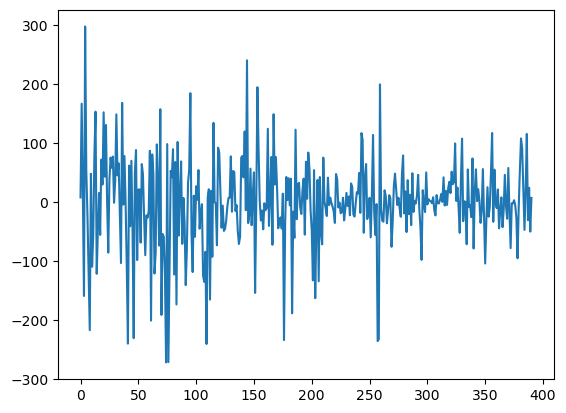

In [18]:
plt.plot(range(391), y_test[1:] - naive);

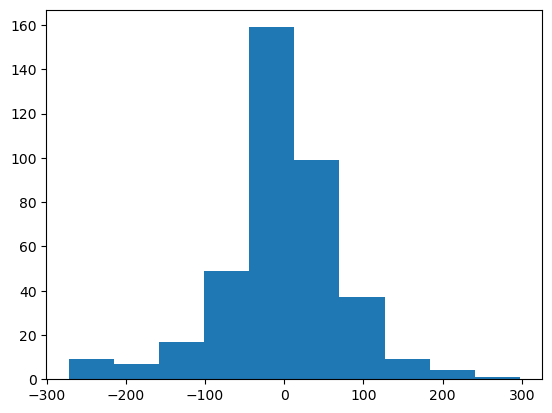

In [19]:
plt.hist(y_test[1:] - naive);

In [20]:
prices_train = prices[:train_size]
prices_test = prices[train_size:]

In [21]:
def prepare_sets(seq):
  target = seq[:-1]
  label = seq[-1:]
  return target, label

In [22]:
train_data = tf.data.Dataset.from_tensor_slices(prices_train)
train_data = train_data.batch(51, drop_remainder=True)
train_dataset = train_data.map(prepare_sets)

train_dataset = train_dataset.batch(10, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(prices_test)
test_data = test_data.batch(51, drop_remainder=True)
test_dataset = test_data.map(prepare_sets)

test_dataset = test_dataset.batch(6, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [23]:
for targets, labels in train_dataset.take(1):
  print(len(targets[0]))

50


In [24]:
dense_neurons = 128
input_size = 50
EPOCHS_DENSE = 150

In [25]:
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, GlobalAveragePooling1D

inputs = Input(shape=(input_size,))
x = Dense(dense_neurons, activation='relu')(inputs)
outputs = Dense(1)(x)

model_dense_1 = tf.keras.Model(inputs, outputs)

In [26]:
model_dense_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mae',
                      metrics=['mae', 'mse'])

In [27]:
history_dense_1 = model_dense_1.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs=EPOCHS_DENSE,
                  steps_per_epoch=len(train_dataset),
                  validation_steps=len(test_dataset))

Epoch 1/150
3/3 [==============================] - 1s 66ms/step - loss: 1060.6818 - mae: 1060.6818 - mse: 2539685.5000 - val_loss: 1157.0505 - val_mae: 1157.0505 - val_mse: 1638554.3750
Epoch 2/150
3/3 [==============================] - 0s 16ms/step - loss: 434.6096 - mae: 434.6096 - mse: 450112.4688 - val_loss: 303.4278 - val_mae: 303.4278 - val_mse: 224657.7344
Epoch 3/150
3/3 [==============================] - 0s 15ms/step - loss: 336.4048 - mae: 336.4048 - mse: 470873.1875 - val_loss: 858.9980 - val_mae: 858.9980 - val_mse: 1051906.1250
Epoch 4/150
3/3 [==============================] - 0s 16ms/step - loss: 420.7952 - mae: 420.7952 - mse: 605347.3125 - val_loss: 812.4180 - val_mae: 812.4180 - val_mse: 953691.2500
Epoch 5/150
3/3 [==============================] - 0s 14ms/step - loss: 310.4382 - mae: 310.4382 - mse: 321062.0938 - val_loss: 430.1666 - val_mae: 430.1666 - val_mse: 373801.0312
Epoch 6/150
3/3 [==============================] - 0s 15ms/step - loss: 239.9485 - mae: 239.9

In [28]:
labels = test_dataset.unbatch().map(lambda target, label: label)
targets = test_dataset.unbatch().map(lambda target, label: tf.expand_dims(target, axis=0))
for i in targets:
  print(i)

tf.Tensor(
[[2590.359619 2598.067139 2764.535645 2781.111816 2621.801758 2919.201172
  2972.485107 2950.118408 2834.468994 2617.156006 2664.831055 2555.037354
  2497.77124  2576.747559 2729.783447 2608.048584 2559.562988 2574.75415
  2518.94458  2590.696045 2620.149658 2772.055664 2814.854492 2945.343018
  2946.25708  2860.459229 2897.976563 2973.131104 3031.067139 3108.062012
  3106.671387 3143.178955 3291.577637 3336.634521 3401.987793 3385.157959
  3281.642822 3449.552246 3445.059326 3522.833496 3521.241211 3411.79248
  3171.691895 3233.274658 3192.073975 3261.91626  3211.866943 2981.052246
  3030.376465 3118.344238]], shape=(1, 50), dtype=float64)
tf.Tensor(
[[3040.916504 3062.310303 2993.40332  3057.606689 3104.106445 3077.74585
  2987.480713 2964.835693 2938.114014 2922.732666 3009.393555 2808.29834
  2888.929688 2936.940918 2815.601807 2730.186768 2827.756104 2857.4104
  2783.476318 2940.644775 2749.213135 2694.979736 2636.093018 2517.459961
  2245.43042  2343.510986 2072.108643

In [29]:
for i in labels.take(1):
  print(i)

tf.Tensor([3019.909424], shape=(1,), dtype=float64)


In [30]:
labelsNaive = []
for i in labels:
  labelsNaive.append(i[0])

labelsNaive = np.array(labelsNaive)
naivePreds = labelsNaive[1:]

naiveMAE = np.absolute(np.mean(naivePreds - labelsNaive[:-1]))
naiveMAE

360.18947760000003

In [31]:
y_preds = np.array(tf.squeeze(model_dense_1.predict(targets)))
y_preds

array([3659.2598, 2366.718 , 1865.1031, 2099.038 , 1828.463 , 1458.2692],
      dtype=float32)

In [32]:
y_true = []
for i in labels:
  y_true.append(int(i[0]))
y_true

[3019, 1801, 1445, 1634, 1645, 1218]

In [33]:
np.mean(np.absolute(y_true - y_preds)) / naiveMAE

1.1636704904346074

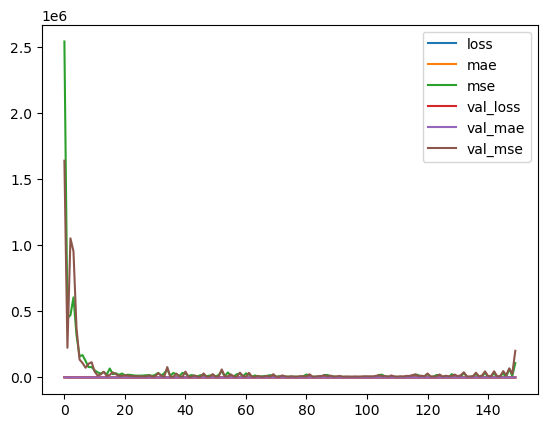

In [34]:
hist_dense_1 = pd.DataFrame(history_dense_1.history)
hist_dense_1.plot();

In [35]:
lstm_neurons = 128
dense_neurons = 64
input_size = 50
EPOCHS_LSTM = 150

In [36]:
from tensorflow.keras.layers import Lambda, LSTM, Dropout, GlobalMaxPooling1D

inputs = Input(shape=(input_size,))
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = LSTM(lstm_neurons, return_sequences=True, activation='relu')(x)
x = LSTM(int(lstm_neurons/2), return_sequences=False, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model_lstm_1 = tf.keras.Model(inputs, outputs)

In [37]:
model_lstm_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mae',
                      metrics=['mae', 'mse'])

In [38]:
history_lstm_1 = model_lstm_1.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs=EPOCHS_LSTM,
                  steps_per_epoch=len(train_dataset),
                  validation_steps=len(test_dataset))

Epoch 1/150
3/3 [==============================] - 2s 155ms/step - loss: 859.0084 - mae: 859.0084 - mse: 1808412.2500 - val_loss: 1350.0311 - val_mae: 1350.0311 - val_mse: 1954202.8750
Epoch 2/150
3/3 [==============================] - 0s 26ms/step - loss: 680.2217 - mae: 680.2217 - mse: 1048233.0625 - val_loss: 1139.2788 - val_mae: 1139.2788 - val_mse: 1415766.8750
Epoch 3/150
3/3 [==============================] - 0s 27ms/step - loss: 527.2762 - mae: 527.2762 - mse: 743439.0000 - val_loss: 740.7388 - val_mae: 740.7388 - val_mse: 618275.5000
Epoch 4/150
3/3 [==============================] - 0s 25ms/step - loss: 361.6662 - mae: 361.6662 - mse: 478379.1562 - val_loss: 471.4143 - val_mae: 471.4143 - val_mse: 292084.5312
Epoch 5/150
3/3 [==============================] - 0s 26ms/step - loss: 294.6474 - mae: 294.6474 - mse: 315390.3750 - val_loss: 297.4362 - val_mae: 297.4362 - val_mse: 102839.8984
Epoch 6/150
3/3 [==============================] - 0s 26ms/step - loss: 292.6742 - mae: 292

In [39]:
y_preds = np.array(tf.squeeze(model_lstm_1.predict(targets)))
y_preds

array([3103.7783, 1651.4794, 1317.0077, 1576.9913, 1463.8116, 1152.152 ],
      dtype=float32)

In [40]:
y_true = []
for i in labels:
  y_true.append(int(i[0]))
y_true

[3019, 1801, 1445, 1634, 1645, 1218]

In [41]:
np.mean(np.absolute(y_true - y_preds)) / naiveMAE

0.3083267489058086

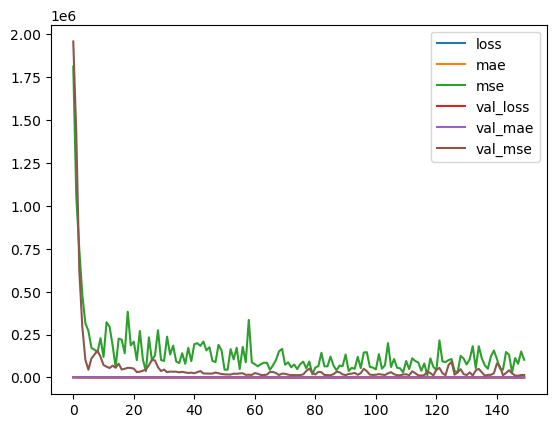

In [42]:
hist_lstm_1 = pd.DataFrame(history_lstm_1.history)
hist_lstm_1.plot();

In [43]:
prices_train = prices[:train_size]
prices_test = prices[train_size:]

In [44]:
def prepare_sets(seq):
  target = seq[:-1]
  label = seq[1:]
  return target, label

In [45]:
train_data = tf.data.Dataset.from_tensor_slices(prices_train)
train_data = train_data.batch(51, drop_remainder=True)
train_dataset = train_data.map(prepare_sets)

train_dataset = train_dataset.batch(10, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(prices_test)
test_data = test_data.batch(51, drop_remainder=True)
test_dataset = test_data.map(prepare_sets)

test_dataset = test_dataset.batch(6, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [46]:
for targets, labels in train_dataset.take(1):
  print(targets[0], labels[0])

tf.Tensor(
[320.884003 299.252991 314.681    307.90799  316.716003 337.631012
 333.356995 330.924011 332.394012 347.612    354.385986 366.730011
 360.401001 380.652008 410.165985 474.911011 466.276001 471.329987
 480.355011 472.902008 427.52301  447.114014 466.540009 463.449005
 465.852997 470.20401  463.281006 428.588013 434.40799  456.031006
 473.502014 441.721008 515.135986 651.43103  702.767029 695.815979
 684.447998 696.208984 719.974976 794.64502  826.822998 819.085999
 821.062988 674.859985 719.387024 694.14801  765.833984 773.835999
 762.84198  737.02301 ], shape=(50,), dtype=float64) tf.Tensor(
[299.252991 314.681    307.90799  316.716003 337.631012 333.356995
 330.924011 332.394012 347.612    354.385986 366.730011 360.401001
 380.652008 410.165985 474.911011 466.276001 471.329987 480.355011
 472.902008 427.52301  447.114014 466.540009 463.449005 465.852997
 470.20401  463.281006 428.588013 434.40799  456.031006 473.502014
 441.721008 515.135986 651.43103  702.767029 695.81597

In [47]:
input_size=50
output_size=50
dense_neurons=128
EPOCHS_DENSE_2=150

In [48]:
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, GlobalAveragePooling1D

inputs = Input(shape=(input_size,))
x = Dense(dense_neurons, activation='relu')(inputs)
outputs = Dense(output_size)(x)

model_dense_2 = tf.keras.Model(inputs, outputs)

In [49]:
model_dense_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mae',
                      metrics=['mae', 'mse'])

In [50]:
history_dense_2 = model_dense_2.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs=EPOCHS_DENSE_2,
                  steps_per_epoch=len(train_dataset),
                  validation_steps=len(test_dataset))

Epoch 1/150
3/3 [==============================] - 0s 57ms/step - loss: 1004.6215 - mae: 1004.6215 - mse: 3061814.2500 - val_loss: 1798.2046 - val_mae: 1798.2046 - val_mse: 4550915.5000
Epoch 2/150
3/3 [==============================] - 0s 18ms/step - loss: 845.6949 - mae: 845.6949 - mse: 2313409.5000 - val_loss: 1501.9750 - val_mae: 1501.9750 - val_mse: 3385030.2500
Epoch 3/150
3/3 [==============================] - 0s 27ms/step - loss: 698.1431 - mae: 698.1431 - mse: 1705719.1250 - val_loss: 1214.7347 - val_mae: 1214.7347 - val_mse: 2437317.2500
Epoch 4/150
3/3 [==============================] - 0s 21ms/step - loss: 564.9777 - mae: 564.9777 - mse: 1231272.8750 - val_loss: 961.7252 - val_mae: 961.7252 - val_mse: 1715716.1250
Epoch 5/150
3/3 [==============================] - 0s 17ms/step - loss: 450.6618 - mae: 450.6618 - mse: 871978.9375 - val_loss: 758.7012 - val_mae: 758.7012 - val_mse: 1186494.6250
Epoch 6/150
3/3 [==============================] - 0s 20ms/step - loss: 363.6740 - 

In [51]:
y_preds = np.array(tf.squeeze([i[-1:] for i in model_dense_2.predict(targets)]))
y_preds

array([784.3173  , 927.1222  , 439.75076 , 610.07776 , 487.8296  ,
       223.41444 , 209.52826 ,  97.761986, 112.76332 , 149.21936 ],
      dtype=float32)

In [52]:
y_true = []
for i in labels:
  y_true.append(int(i[0]))
y_true

[299, 756, 895, 492, 591, 450, 183, 200, 130, 122]

In [53]:
np.mean(np.absolute(y_true - y_preds)) / naiveMAE

0.4810647997462586

In [54]:
train_data = tf.data.Dataset.from_tensor_slices(prices_train)
train_data = train_data.batch(9, drop_remainder=True)
train_dataset = train_data.map(prepare_sets)

train_dataset = train_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(prices_test)
test_data = test_data.batch(9, drop_remainder=True)
test_dataset = test_data.map(prepare_sets)

test_dataset = test_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [55]:
lstm_neurons=256
input_size=8
output_size=8
EPOCHS_LSTM_2=28

In [56]:
from tensorflow.keras.layers import Bidirectional

inputs = Input(shape=(input_size,))

x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = Bidirectional(LSTM(lstm_neurons, return_sequences=True, activation='relu'))(x)
x = Bidirectional(LSTM(int(lstm_neurons/2), return_sequences=True, activation='relu'))(x)
x = Dropout(0.1)(x)
x = LSTM(int(lstm_neurons), return_sequences=True, activation='relu')(x)
x = LSTM(int(lstm_neurons/2), return_sequences=False, activation='relu')(x)
outputs = Dense(output_size)(x)

model_lstm_2 = tf.keras.Model(inputs, outputs)

In [57]:
model_lstm_2.compile(optimizer=tf.keras.optimizers.Adam(), 
                     loss='mae', 
                     metrics=['mae'])

In [58]:
history_lstm_2 = model_lstm_2.fit(train_dataset,
                 validation_data=test_dataset,
                 epochs=EPOCHS_LSTM_2,
                 steps_per_epoch=len(train_dataset),
                 validation_steps=len(test_dataset))

Epoch 1/28
5/5 [==============================] - 5s 190ms/step - loss: 750.1055 - mae: 750.1055 - val_loss: 1837.7059 - val_mae: 1837.7059
Epoch 2/28
5/5 [==============================] - 0s 26ms/step - loss: 722.0637 - mae: 722.0637 - val_loss: 1717.9209 - val_mae: 1717.9209
Epoch 3/28
5/5 [==============================] - 0s 26ms/step - loss: 615.7173 - mae: 615.7173 - val_loss: 1330.5112 - val_mae: 1330.5112
Epoch 4/28
5/5 [==============================] - 0s 25ms/step - loss: 326.9070 - mae: 326.9070 - val_loss: 511.2447 - val_mae: 511.2447
Epoch 5/28
5/5 [==============================] - 0s 31ms/step - loss: 263.9250 - mae: 263.9250 - val_loss: 474.1562 - val_mae: 474.1562
Epoch 6/28
5/5 [==============================] - 0s 26ms/step - loss: 114.0160 - mae: 114.0160 - val_loss: 244.4740 - val_mae: 244.4740
Epoch 7/28
5/5 [==============================] - 0s 26ms/step - loss: 98.6906 - mae: 98.6906 - val_loss: 188.3587 - val_mae: 188.3587
Epoch 8/28
5/5 [====================

<Axes: >

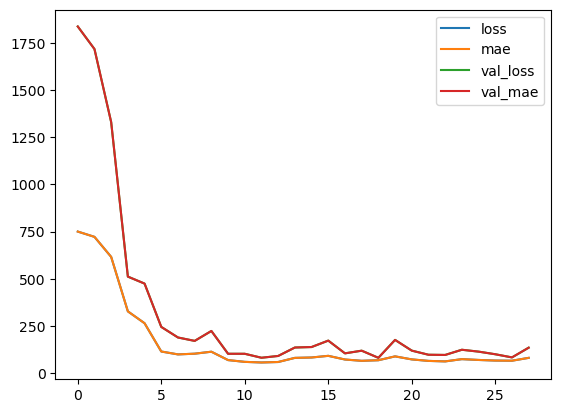

In [59]:
hist_lstm_2 = pd.DataFrame(history_lstm_2.history)
hist_lstm_2.plot()

In [60]:
labels = test_dataset.unbatch().map(lambda target, label: label)
targets = test_dataset.unbatch().map(lambda target, label: tf.expand_dims(target, axis=0))

In [61]:
labelsNaive = []
for i in labels:
  labelsNaive.append(i[7])

labelsNaive = np.array(labelsNaive)
naivePreds = labelsNaive[1:]

naiveMAE = np.absolute(np.mean(naivePreds - labelsNaive[:-1]))
naiveMAE

51.678435290322575

In [62]:
y_preds = []
model_horizon_preds = np.array(tf.squeeze(model_lstm_2.predict(targets)))

for i in model_horizon_preds:
  y_preds.append(i[len(i)-1])

y_preds

[2661.4387,
 2488.2905,
 2642.6177,
 3046.3347,
 3225.6921,
 2971.8218,
 2883.931,
 2730.8518,
 2216.081,
 1948.7219,
 1802.8475,
 1738.9126,
 1175.5485,
 1117.5303,
 1062.9221,
 1116.2397,
 1458.212,
 1567.5862,
 1674.0913,
 1738.3114,
 1508.916,
 1516.5334,
 1556.6592,
 1263.737,
 1273.9246,
 1257.8062,
 1247.0266,
 1458.8328,
 1410.1332,
 1187.3784,
 1126.6885,
 1210.2842]

In [63]:
y_true = []
for i in labels:
  y_true.append(i[len(i)-1].numpy())

y_true

[2834.468994,
 2574.75415,
 2897.976563,
 3385.157959,
 3192.073975,
 2993.40332,
 2808.29834,
 2749.213135,
 2056.273926,
 1972.181885,
 1823.569336,
 1665.042236,
 1127.656494,
 1144.579224,
 1237.593384,
 1352.626465,
 1445.383423,
 1618.874512,
 1957.24646,
 1619.31897,
 1523.838867,
 1635.347656,
 1469.741699,
 1335.32019,
 1352.837158,
 1297.422119,
 1363.447021,
 1579.70459,
 1299.4646,
 1218.426758,
 1170.086182,
 1232.4375]

In [64]:
eval_preds(np.array(y_true), np.array(y_preds))

,MAE,MSE,RMSE,MASE
Score:,96.50996,16317.57762,127.740274,0.996465


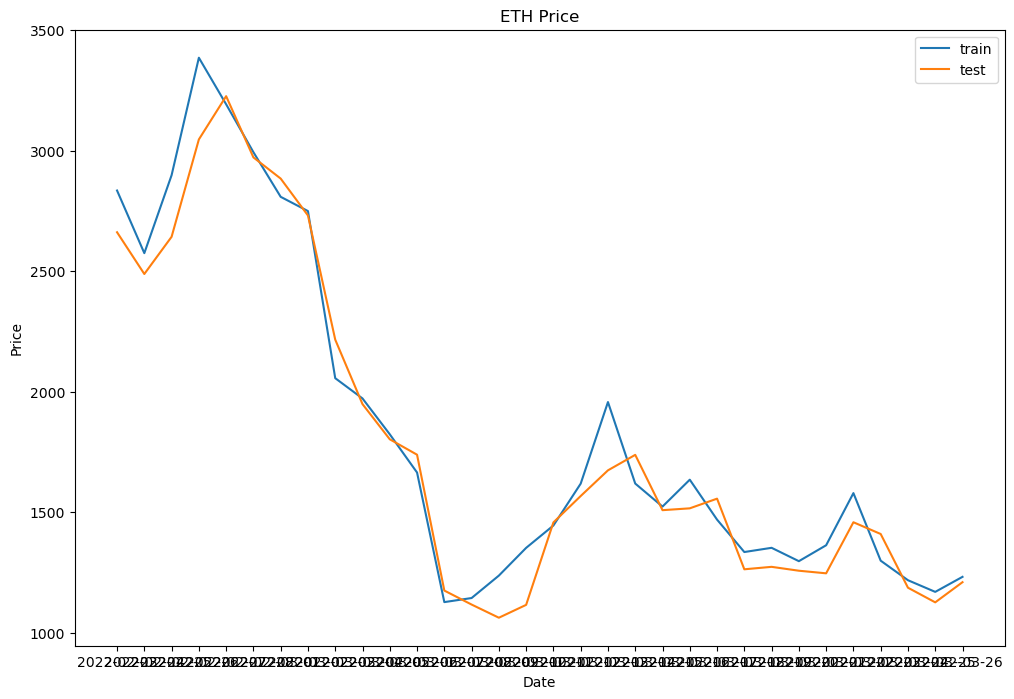

In [65]:
plot_sets(X_test[:32], y_true, X_test[:32], y_preds)

In [66]:
btc_df = pd.read_csv('./BTC-USD.csv', index_col=['Date'])

In [67]:
btc_df =  pd.DataFrame(btc_df['Close']).rename(columns={'Close':"Price"})

In [68]:
btc_df = btc_df.head(1959)
btc_df

,Price
Date,
2017-11-09,7143.580078
2017-11-10,6618.140137
2017-11-11,6357.600098
2017-11-12,5950.069824
2017-11-13,6559.490234
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


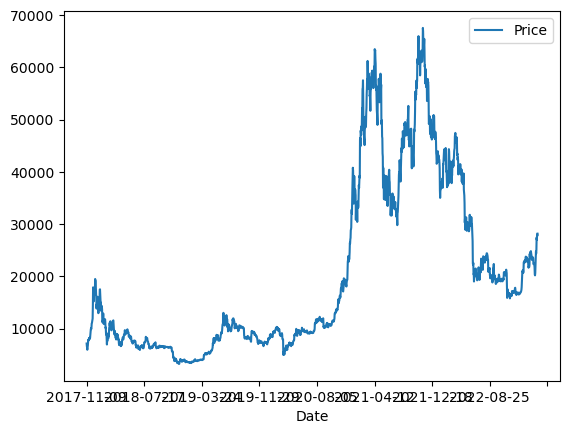

In [69]:
btc_df.plot();

In [70]:
len(btc_df['Price'])

1959

In [71]:
len(eth_price['Price'])

1959

<Axes: xlabel='Date'>

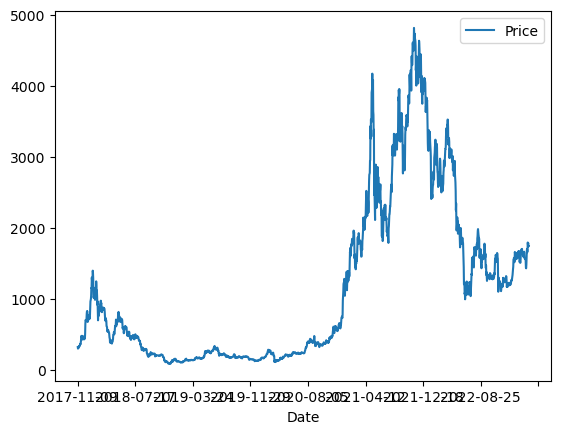

In [72]:
eth_price.plot()

In [73]:
btc_price = btc_df['Price'].to_numpy()
btc_price

array([ 7143.580078,  6618.140137,  6357.600098, ..., 28038.675781,
       27767.236328, 28175.816406])

In [74]:
split_range = int(len(btc_price) * 0.8)
btc_train = btc_price[:split_range]
btc_test = btc_price[split_range:]

In [75]:
def prepare_eth_btc_sets(seq):
  target = seq[:-1]
  label = seq[-1:]
  return target, label

In [76]:
# BTC
train_data_btc = tf.data.Dataset.from_tensor_slices(btc_train)
train_data_btc = train_data_btc.batch(9, drop_remainder=True)
train_dataset_btc = train_data_btc.map(prepare_eth_btc_sets)
train_dataset_btc = train_dataset_btc.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_data_btc = tf.data.Dataset.from_tensor_slices(btc_test)
test_data_btc = test_data_btc.batch(9, drop_remainder=True)
test_dataset_btc = test_data_btc.map(prepare_eth_btc_sets)
test_dataset_btc = test_dataset_btc.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# ETH
train_data_eth = tf.data.Dataset.from_tensor_slices(prices_train)
train_data_eth = train_data_eth.batch(9, drop_remainder=True)
train_dataset_eth = train_data_eth.map(prepare_eth_btc_sets)

train_dataset_eth = train_dataset_eth.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_data_eth = tf.data.Dataset.from_tensor_slices(prices_test)
test_data_eth = test_data_eth.batch(9, drop_remainder=True)
test_dataset_eth = test_data_eth.map(prepare_eth_btc_sets)

test_dataset_eth = test_dataset_eth.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [77]:
train_btc = []
for i in train_dataset_btc.unbatch().map(lambda target, label: target):
  train_btc.append(tf.expand_dims(i, axis=0))

In [78]:
train_eth = []
for i in train_dataset_btc.unbatch().map(lambda target, label: target):
  train_eth.append(tf.expand_dims(i, axis=0))

In [79]:
labels_train = []
for i in train_dataset_btc.unbatch().map(lambda target, label: label):
  labels_train.append(i)

In [80]:
train_data_eth_btc = tf.data.Dataset.from_tensor_slices((train_eth, train_btc))
train_labels_eth_btc = tf.data.Dataset.from_tensor_slices(labels_train)
train_dataset_eth_btc = tf.data.Dataset.zip((train_data_eth_btc, train_labels_eth_btc)) 

In [81]:
for target, label in train_dataset_eth_btc.take(1):
  print(tf.expand_dims(target[0], axis=0).shape)

(1, 1, 8)


In [82]:
input_size=8
output_size=1
EPOCHS_CONCAT_1=90
lstm_neurons=256

In [83]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Lambda
# ETH
inputs_eth = Input(shape=(input_size,))
lambda_eth = Lambda(lambda x: tf.expand_dims(x, axis=0))(inputs_eth)
x_eth = LSTM(lstm_neurons, return_sequences=False, activation='relu')(lambda_eth)
outputs_eth = Dropout(0.2)(x_eth)
model_eth = tf.keras.Model(inputs=inputs_eth, outputs=outputs_eth)

# BTC
inputs_btc = Input(shape=(input_size,))
lambda_btc = Lambda(lambda x: tf.expand_dims(x, axis=0))(inputs_btc)
x_btc = LSTM(lstm_neurons, return_sequences=False, activation='relu')(lambda_btc)
outputs_btc = Dropout(0.2)(x_btc)
model_btc = tf.keras.Model(inputs=inputs_btc, outputs=outputs_btc)

# Concat 
eth_btc_concat = Concatenate()([model_eth.output, model_btc.output])

lambda_eth_btc = Lambda(lambda x: tf.expand_dims(x, axis=0))(eth_btc_concat)
x = LSTM(lstm_neurons, return_sequences=False, activation='relu')(lambda_eth_btc)
x = Dropout(0.2)(x)
outputs = Dense(8)(x)

model_concat = tf.keras.Model(inputs=[model_eth.input, model_btc.input], outputs=outputs)

In [84]:
model_concat.compile(optimizer=tf.keras.optimizers.Adam(), 
                     loss='mae', 
                     metrics=['mae'])

In [85]:
model_concat.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 lambda_2 (Lambda)              (1, None, 8)         0           ['input_5[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              (1, None, 8)         0           ['input_6[0][0]']                
                                                                                            

In [86]:
model_concat.fit(train_dataset_eth_btc, 
                 steps_per_epoch=len(train_dataset_eth_btc),
                 epochs=EPOCHS_CONCAT_1)

Epoch 1/90
160/160 [==============================] - 3s 11ms/step - loss: 4686.1543 - mae: 4686.1543
Epoch 2/90
160/160 [==============================] - 2s 11ms/step - loss: 2317.5103 - mae: 2317.5103
Epoch 3/90
160/160 [==============================] - 2s 10ms/step - loss: 2690.3110 - mae: 2690.3110
Epoch 4/90
160/160 [==============================] - 2s 11ms/step - loss: 2557.1311 - mae: 2557.1311
Epoch 5/90
160/160 [==============================] - 2s 11ms/step - loss: 2227.0659 - mae: 2227.0659
Epoch 6/90
160/160 [==============================] - 2s 10ms/step - loss: 2161.4922 - mae: 2161.4922
Epoch 7/90
160/160 [==============================] - 2s 10ms/step - loss: 2051.1768 - mae: 2051.1768
Epoch 8/90
160/160 [==============================] - 2s 11ms/step - loss: 2414.3567 - mae: 2414.3567
Epoch 9/90
160/160 [==============================] - 2s 10ms/step - loss: 1948.7848 - mae: 1948.7848
Epoch 10/90
160/160 [==============================] - 2s 11ms/step - loss: 1986.6